**Задача: научиться идентифицировать пользователей по статистике посещения сайтов. **
    
Есть данные по пользователям, разложены по папкам на разное количество пользователей. Так как модели тренировать - долгий процесс, вначале будем все рассматривать на небольшом количестве пользователеей (папки по 3, 10 и 150 пользователей). В самом конце пробуем обучить модель на 3000 пользователей.

In [4]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import pickle
import itertools
#pip install tqdm
from tqdm import tqdm 
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
%matplotlib inline
from matplotlib import pyplot as plt

# 1. Предварительный анализ и преобразование данных

Вначале посмотрим, что за данные у нас в наличии, на примере одного пользователя

In [3]:

PATH_TO_DATA = 'datasets' 

user31_data = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                       '10users/user0031.csv'))

user31_data.head()

,timestamp,site
0,2013-11-15 08:12:07,fpdownload2.macromedia.com
1,2013-11-15 08:12:17,laposte.net
2,2013-11-15 08:12:17,www.laposte.net
3,2013-11-15 08:12:17,www.google.com
4,2013-11-15 08:12:18,www.laposte.net


**Видим, что по каждому пользователю у нас по файлу csv, в котором данные о просмотренных сайтах. Данные состоят из столбца с временем посещения сайта и адресом сайта.**

In [4]:
user31_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 2 columns):
timestamp    7600 non-null object
site         7600 non-null object
dtypes: object(2)
memory usage: 118.8+ KB


По данному конкретному пользователю - 7600 посещенных им сайтов

In [5]:
user31_data.site.describe()

count                    7600
unique                    962
top       webmail.laposte.net
freq                      399
Name: site, dtype: object

При этом уникальных сайтов меньше тысячи

In [7]:
user31_data.timestamp.min(), user31_data.timestamp.max()

('2013-11-15 08:12:07', '2014-03-28 13:09:07')

Данные распространяются на несколько месяцев интернет-активности

Пробуем создать из этиъ файлов по пользователям один файл. В нем будет отражено, какие сайты подряд просматривал каждый из пользователей. Названия сайтов будут преобразованы в индексы, сами названия можно будет проверить по файлу-словарю (в котором названию сайта соответствует его индекс и сколько раз он встерчался в датасете). Данные о пользователях тогда будут выглядеть таким образом:
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-s6z2{text-align:center}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-hgcj{font-weight:bold;text-align:center}
.tg .tg-amwm{font-weight:bold;text-align:center;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-hgcj">session_id</th>
    <th class="tg-hgcj">site1</th>
    <th class="tg-hgcj">site2</th>
    <th class="tg-amwm">user_id</th>
  </tr>
  <tr>
    <td class="tg-s6z2">1</td>
    <td class="tg-s6z2">1</td>
    <td class="tg-s6z2">2</td>
    <td class="tg-baqh">1</td>
  </tr>
  <tr>
    <td class="tg-s6z2">2</td>
    <td class="tg-s6z2">1</td>
    <td class="tg-s6z2">3</td>
    <td class="tg-baqh">1</td>
  </tr>
  <tr>
    <td class="tg-s6z2">3</td>
    <td class="tg-s6z2">3</td>
    <td class="tg-s6z2">2</td>
    <td class="tg-baqh">2</td>
  </tr>
  <tr>
    <td class="tg-s6z2">4</td>
    <td class="tg-s6z2">4</td>
    <td class="tg-s6z2">3</td>
    <td class="tg-baqh">2</td>
  </tr>
</table>

**Для начала зададим длину сессии 10 сайтов, то есть каждой строчке будут соответствовать 10 сайтов, просмотренных подряд каким-либо пользователем.**

**Дополнительно убедимся, чтобы не множились одни и те же сайты, записанные по-разному (выше заметно, что сайт laposte был записан и как laposte.net, и как www.laposte.net). При этом специально оставляем значимые префиксы и доменные имена, потому что они могут быть полезны при идентификации пользователей.**

In [6]:
def name_columns(session_length):
    
    columns = []
    for index in range(session_length):
        columns.append(''.join(['site', str(index+1)]))
    columns.append('user_id')
    return columns


def prepare_train_set(path_to_csv_files, session_length=10):

    files = glob(os.path.join(path_to_csv_files, 
                                       '*.csv'))
    sites_freq = {}
    current_id = 1
    
    columns = name_columns(session_length)
    
    df = pd.DataFrame(columns=columns)
    
    user_id = 1
    
    for file in tqdm(files):
        user_df = pd.read_csv(file)
        user_sites = user_df.site.values
        user_sites_ids = []
        
        for site in user_sites:
            # убираем лишние префиксы в названии сайта
            correct_site = site.replace("www.", "")
            correct_site = correct_site.replace("http://", "")
            correct_site = correct_site.replace("https://", "")

            if correct_site in sites_freq:
                site_id = sites_freq[correct_site][0]
                count = sites_freq[correct_site][1] + 1
                sites_freq[correct_site] = (site_id, count)
                user_sites_ids.append(site_id)
                
            else:
                sites_freq[correct_site] = (current_id, 1)
                user_sites_ids.append(current_id)
                current_id += 1
              
        if len(user_sites) % session_length != 0:
            user_sites_ids = np.pad(user_sites_ids, (0, session_length - len(user_sites_ids) % session_length), 'constant')
        user_sites_ids = np.reshape(user_sites_ids, [-1, session_length])
        user_ids = np.array([user_id for i in range(user_sites_ids.shape[0])])
        user_ids = np.reshape(user_ids, [user_sites_ids.shape[0], -1])
        user_sites_ids = np.hstack([user_sites_ids, user_ids])
        
        df_new = pd.DataFrame(user_sites_ids, columns=columns)
        df = df.append(df_new)

        user_id += 1
        
    return df, sites_freq

Определили нужные функции, теперь применим их к нашим датасетам, с 10 и с 150 пользователями.

In [7]:
%%time
train_data_10users, site_freq_10users = prepare_train_set(os.path.join(PATH_TO_DATA, '10users'), 
                                                     session_length=10)

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 13.60it/s]


Wall time: 746 ms


In [8]:
%%time
train_data_150users, site_freq_150users = prepare_train_set(os.path.join(PATH_TO_DATA, '150users'), 
                                                     session_length=10)

100%|████████████████████████████████████████| 150/150 [00:07<00:00, 19.39it/s]


Wall time: 7.98 s


### Проведем анализ полученного датасета со 150 пользователями

Посмотрим количество уникальных сайтов, а также на самые популярные и самые редкие сайты

In [9]:
len(site_freq_150users)

27287

In [10]:
sites = pd.DataFrame(site_freq_150users)
sorted_sites = sites.sort_values(by=1, axis=1, ascending=False, kind='mergesort')
top15_popular = list(sorted_sites.columns[:15])

In [11]:
top15_popular

['google.fr',
 'google.com',
 'facebook.com',
 'apis.google.com',
 's.youtube.com',
 'clients1.google.com',
 'mail.google.com',
 'plus.google.com',
 'safebrowsing-cache.google.com',
 'youtube.com',
 'twitter.com',
 'platform.twitter.com',
 's-static.ak.facebook.com',
 'accounts.google.com',
 'bing.com']

In [14]:
sorted_sites = sites.sort_values(by=1, axis=1, ascending=True, kind='mergesort')
top15_unpopular = list(sorted_sites.columns[:15])
top15_unpopular

['0.static.wix.com',
 '00.art.skyrock.net',
 '02.img.v4.skyrock.net',
 '045-qrg-025.mktoresp.com',
 '05.wir.skyrock.net',
 '08.mgl.skyrock.net',
 '0f.img.v4.skyrock.net',
 '0img.imgo.tv',
 '0w2myakzob.s.ad6media.fr',
 '1.images.gametrailers.com',
 '1.viki.io',
 '1001pharmacies.com',
 '100p100arbitres.com',
 '101cookbooks.com',
 '10parjour.net']

Смотрим распределение целевого класса, на сколько уникальных сайтов заходят разные пользователи:

In [24]:
train_data_150users['user_id'].value_counts()

103    4653
21     3152
104    2954
29     2796
102    2675
93     2607
8      2204
1      2137
4      2094
97     2049
60     2039
59     1953
37     1868
23     1752
146    1722
28     1712
5      1651
88     1645
42     1643
130    1630
62     1612
100    1562
138    1544
41     1537
56     1493
80     1476
125    1438
64     1401
51     1382
24     1370
       ... 
78      462
69      461
112     456
40      445
31      442
128     442
75      441
119     441
70      435
137     434
114     429
127     423
13      422
126     415
136     411
87      409
123     406
108     405
55      400
33      400
86      399
67      396
30      395
48      394
9       394
84      390
77      382
110     377
135     365
145     351
Name: user_id, Length: 150, dtype: int64

**Сохраним полученные датасеты и словари на диск в формате разреженных матриц**

In [25]:
def convert_to_sparce(users_history):
    indices = users_history.flatten()
    indptr = [num for num in range(0, indices.shape[0]+1, users_history.shape[1])]
    data = np.ones(indices.shape)
    return csr_matrix((data, indices, indptr), (users_history.shape[0], len(np.unique(users_history))))[:, 1:]


In [26]:
X_10users, y_10users = train_data_10users.iloc[:, :-1].values, \
                       train_data_10users.iloc[:, -1].values
X_150users, y_150users = train_data_150users.iloc[:, :-1].values, \
                         train_data_150users.iloc[:, -1].values
    
X_sparse_10users = convert_to_sparce(X_10users)
X_sparse_150users = convert_to_sparce(X_150users)

In [28]:
with open(os.path.join(PATH_TO_DATA, 
                       'X_sparse_10users.pkl'), 'wb') as X10_pkl:
    pickle.dump(X_sparse_10users, X10_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'wb') as y10_pkl:
    pickle.dump(y_10users, y10_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'X_sparse_150users.pkl'), 'wb') as X150_pkl:
    pickle.dump(X_sparse_150users, X150_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'y_150users.pkl'), 'wb') as y150_pkl:
    pickle.dump(y_150users, y150_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'site_freq_10users.pkl'), 'wb') as site_freq_10users_pkl:
    pickle.dump(site_freq_10users, site_freq_10users_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'site_freq_150users.pkl'), 'wb') as site_freq_150users_pkl:
    pickle.dump(site_freq_150users, site_freq_150users_pkl, protocol=2)

**Посчитаем распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов.**

In [33]:
num_unique_sites = [np.unique(train_data_10users.values[i, :-1]).shape[0] 
                    for i in range(train_data_10users.shape[0])]
pd.Series(num_unique_sites).value_counts()

7     2311
6     2205
8     2038
5     1756
9     1368
2     1248
4     1173
3      897
10     638
1      427
dtype: int64

**Проверим гипотезу о том, что пользователь хотя бы раз зайдет на сайт, который он уже ранее посетил в сессии из 10 сайтов. Проверим с помощью биномиального критерия для доли, что доля случаев, когда пользователь повторно посетил какой-то сайт (то есть число уникальных сайтов в сессии < 10) велика: больше 95%. **

In [36]:
has_two_similar = (np.array(num_unique_sites) < 10).astype('int')
pi_val = stats.binom_test(sum(has_two_similar), len(has_two_similar), p=0.95, alternative='greater') 
pi_val

0.0057114607369772776

**И построим для этой доли 95% доверительный интервал Уилсона.**

In [38]:
from statsmodels.stats.proportion import proportion_confint

wilson_interval = proportion_confint(sum(has_two_similar), len(has_two_similar), alpha=0.05, method='wilson')
wilson_interval

(0.95106032697778875, 0.95794387597978881)

**Замечательно, надежда на благоприятный исход и возможность угадывать пользователя по этим данным есть.**

# 2. Подготовка данных для линейных моделей и тренировка простых линейных моделей

Преобразуем данные в разреженные матрицы, чтобы было возможно попробовать на них простые модели.

In [30]:
def name_columns(session_length):
    
    columns = []
    for index in range(session_length):
        columns.append(''.join(['site', str(index+1)]))
    columns.append('user_id')
    return columns

def prepare_train_set_window(path_to_csv_files, site_freq_path, 
                                    session_length=10, window_size=10):


    sites_freq = pickle.load(open(site_freq_path, 'rb'))
    files = glob(os.path.join(path_to_csv_files, '*.csv'))

    user_id = 1
    data_array = np.empty((0, session_length+1), int)
    
    for file in tqdm(files):
        user_df = pd.read_csv(file)
        user_sites = user_df.site.values
        user_sites_ids = []
        
        for site in user_sites:
            # убираем лишние префиксы в названии сайта
            correct_site = site.replace("www.", "")
            correct_site = correct_site.replace("http://", "")
            correct_site = correct_site.replace("https://", "")
            
            site_id = sites_freq[correct_site][0]
            user_sites_ids.append(site_id)
                        
        if len(user_sites_ids) % window_size != 0:
            user_sites_ids = np.pad(user_sites_ids, (0, session_length - len(user_sites_ids) % window_size), 'constant')
        remainder = (len(user_sites_ids) - ((len(user_sites_ids) / window_size) - 1) * window_size) % session_length
        if remainder != 0:
            user_sites_ids = np.pad(user_sites_ids, (0, session_length - int(remainder)), 'constant')
        
        
            
        user_sites_ids = np.vstack([user_sites_ids[i:session_length+i] for i in range(0, len(user_sites), window_size)])
            
        user_ids = np.array([user_id for i in range(user_sites_ids.shape[0])])
        user_ids = np.reshape(user_ids, [user_sites_ids.shape[0], -1])
        user_sites_ids = np.hstack([user_sites_ids, user_ids])

        data_array = np.vstack([data_array, user_sites_ids])

        user_id += 1
    
    return data_array, sites_freq

def prepare_sparse_train_set_window(path_to_csv_files, site_freq_path, 
                                    session_length=10, window_size=10):
    
    data_array, sites_freq = prepare_train_set_window(path_to_csv_files, site_freq_path, 
                                    session_length=session_length, window_size=window_size)
    
    X, y = data_array[:, :-1], data_array[:, -1]
    indices = X.flatten()
    indptr = [num for num in range(0, indices.shape[0]+1, X.shape[1])]
    data = np.ones(indices.shape)
    X = csr_matrix((data, indices, indptr), (X.shape[0], len(sites_freq) + 1))[:, 1:]
    
    return X, y

**Сразу же сохраним данные с разной длиной сессии и разной длиной окна**

In [136]:
%%time

data_lengths = []

for num_users in [10, 150]:
    
    for window_size, session_length in itertools.product([15, 10, 5], [15, 10, 7, 5]):
        
        if window_size <= session_length:
            X_sparse, y = prepare_sparse_train_set_window(os.path.join(PATH_TO_DATA, str(num_users)+'users'), 
                                                       os.path.join(PATH_TO_DATA, 'site_freq_'+str(num_users)+'users.pkl'),
                                       session_length=session_length, window_size=window_size)
            
            with open(os.path.join(PATH_TO_DATA, 
                                   'X_sparse_'+str(num_users)+'users_s'+str(session_length)+'_w'+str(window_size)+'.pkl'), 
                      'wb') as X_pkl:
                pickle.dump(X_sparse, X_pkl, protocol=2)
                
            with open(os.path.join(PATH_TO_DATA, 
                       'y_'+str(num_users)+'users_s'+str(session_length)+'_w'+str(window_size)+'.pkl'), 
                      'wb') as y_pkl:
                pickle.dump(y, y_pkl, protocol=2)
            data_lengths.append(X_sparse.shape[0])

100%|████████████████████████████████████████| 150/150 [00:05<00:00, 28.84it/s]


Wall time: 42.7 s


**Начнем подбирать модель и ее параметры, используя базовый датасет из 10 пользователей, сесссии в 10 сайтов и стандартной ширине окна**

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

# функция для построения графиков по результатам поиска параметров grid search
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [6]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

y_10users = y_10users.astype(np.int)

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

In [8]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Мы знаем, что в таких случаях лучше всего работают линейные модели, поэтому поработаем с ними**

In [39]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

logit = LogisticRegression(random_state=17, n_jobs=-1)
cross_val_score(logit, X_train, y_train, cv=skf).mean()

0.76234560498500425

Кросс-валидация обычно бывает достаточно точным индикатором, но проверим и на отложенной выборке

In [126]:
logit.fit(X_train, y_train)
accuracy_score(y_valid, logit.predict(X_valid))

0.78075373311211183

**Проведем поиск лучшего параметра C**

In [10]:
%%time
logit_c_values1 = np.linspace(3, 7, 10)

logit_grid_searcher1 = LogisticRegressionCV(multi_class='multinomial', random_state=17, cv=skf, n_jobs=-1)
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 22.9 s


In [11]:
scores_for_all_classes = np.sum(np.array([value for key, value in logit_grid_searcher1.scores_.items()]), axis=0) / 10
logit_mean_cv_scores1 = np.sum(scores_for_all_classes, axis=0) / 3  
logit_mean_cv_scores1

array([ 0.31740828,  0.49523171,  0.61867757,  0.71601482,  0.75422041,
        0.76295394,  0.75543426,  0.74273654,  0.7409103 ,  0.73918259])

**Покажем визуально, как меняется аккуратность при разных значениях C**

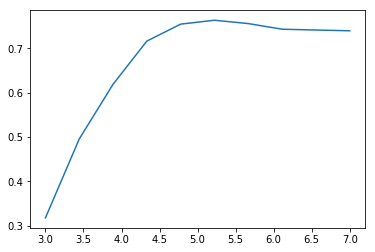

In [90]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

Покажем лучшее значение C и соответствующую аккуратность на кросс-валидации

In [12]:
best_c = logit_c_values1[logit_mean_cv_scores1.argmax()]
best_c, logit_mean_cv_scores1.max()

(5.2222222222222223, 0.76295393759368579)

In [92]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher1.predict(X_valid))
logit_cv_acc

0.77909457217350087

**Теперь попробуем линейный SVM**

In [28]:
%%time

from sklearn.svm import LinearSVC

svm = LinearSVC(C=1, random_state=17)

svm_params = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher = GridSearchCV(svm, svm_params, cv=skf, n_jobs=-1)
svm_grid_searcher.fit(X_train, y_train)

Wall time: 1min


In [96]:
svm_grid_searcher.best_score_, svm_grid_searcher.best_params_ 

(0.76437715911400117, {'C': 0.10434482758620689})

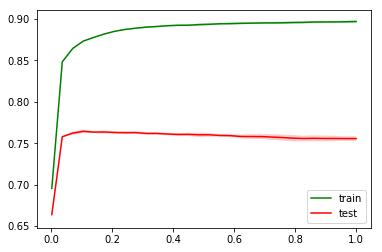

In [97]:
plot_validation_curves(svm_params['C'], svm_grid_searcher.cv_results_)

In [100]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher.predict(X_valid))
svm_cv_acc

0.77909457217350087

**Результаты всех опробованных нами моделей приблизительно одинаковы (в рамках погрешностей). Посмотрим, какое значение от ширины окна и количества сайтов в сессии.**

In [25]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    with open(path_to_X_pickle, 'rb') as f:
        X = pickle.load(f)
    with open(path_to_y_pickle, 'rb') as f:
        y = pickle.load(f)
    y = y.astype(np.int)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=test_size, 
                                                     random_state=random_state, stratify=y)
    
    
    cv_mean = cross_val_score(estimator, X_train, y_train, cv=cv, n_jobs=-1).mean()
    
    estimator.fit(X_train, y_train)
    
    accuracy = accuracy_score(y_valid, estimator.predict(X_valid))
    
    return cv_mean, accuracy

In [29]:
estimator = svm_grid_searcher.best_estimator_

In [139]:

for session_length, window_size in itertools.product([15, 10, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = "./datasets/X_sparse_10users_s" + str(session_length) + "_w" + str(window_size) + ".pkl"
        path_to_y_pkl = "./datasets/y_10users_s" + str(session_length) + "_w" + str(window_size) + ".pkl"
        CV, accuracy = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, cv=skf)
        print("{}: CV: {}, accuracy: {}".format(path_to_X_pkl[28:35], CV, accuracy))

s15_w15: CV: 0.7755197785275921, accuracy: 0.7987913259864913
s15_w10: CV: 0.8222940711593122, accuracy: 0.8392984119459588
s15_w7.: CV: 0.8477203248099773, accuracy: 0.852165256346441
s15_w5.: CV: 0.8671896112653901, accuracy: 0.8749407302038881
s10_w10: CV: 0.7643770124685939, accuracy: 0.7790945721735009
s10_w7.: CV: 0.797862799639289, accuracy: 0.8055417288866766
s10_w5.: CV: 0.8143487040996397, accuracy: 0.8227833096254149
s5_w5.p: CV: 0.7214200131138755, accuracy: 0.735538169748696


**Итак, получается, что длина сессии в 15 сайтов и ширина окна в 5 сайтов - лучшие параметры для данного датасета**

**Рискнем попробовать повторить последний шаг уже для данных по 150 пользователям**

In [30]:
for session_length, window_size in itertools.product([15, 10, 5], [15, 10, 5]):
    if window_size <= session_length:
        path_to_X_pkl = "./datasets/X_sparse_150users_s" + str(session_length) + "_w" + str(window_size) + ".pkl"
        path_to_y_pkl = "./datasets/y_150users_s" + str(session_length) + "_w" + str(window_size) + ".pkl"
        CV, accuracy = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, cv=skf)
        print("{}: CV: {}, accuracy: {}".format(path_to_X_pkl[29:36], CV, accuracy))

s15_w15: CV: 0.4837601093917822, accuracy: 0.5102517329441809
s15_w10: CV: 0.5460882450796428, accuracy: 0.572081934510777
s15_w5.: CV: 0.6104008703556459, accuracy: 0.6326106000876041
s10_w10: CV: 0.45998807394111346, accuracy: 0.48265460030165913
s10_w5.: CV: 0.523446905495096, accuracy: 0.5440818610989439
s5_w5.p: CV: 0.4077351546308323, accuracy: 0.4207426874969582


**Да, результат получается не таким хорошим, но при длине сессии в 15 сайтов и ширине окна в 5 получается не такой уж и плохой результат. Тем не менее надо будет попробовать воспользоваться Vowpal Wabbit и попробовать добавить дополнительные признаки в датасет. Но пока посмотрим, какая вероятность с нашими текущими моделями идентифицировать одного конкретного пользователя: определять по сессии, он это или нет.**

In [36]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)
    
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

In [33]:
print(best_c)

5.22222222222


In [40]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[best_c], multi_class='ovr', n_jobs=-1, random_state=17)
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 9min 15s


In [41]:
logit_cv_150users.scores_[1].mean()

0.99605858279971338

**Красивый результат, но не реалистичный. С таким количеством пользователей константный прогноз "не он" позволяет получить видимость хорошего результата. Посчитаем для каждого пользователя разницу между долей правильных ответов на кросс-валидации  и долей меток, отличных от ID 
 этого пользователя.**

In [42]:
y_train_150 = y_train_150.astype('int')

class_distr = np.bincount(y_train_150.astype('int'))

acc_diff_vs_constant = []

for user_id in np.unique(y_train_150):
    diff = logit_cv_150users.scores_[user_id].mean() - (sum(class_distr) - class_distr[user_id]) / sum(class_distr)
    acc_diff_vs_constant.append(diff)
acc_diff_vs_constant

num_better_than_default = (np.array(list(acc_diff_vs_constant)) > 0).sum()

prop_better_than_default = num_better_than_default / len(np.unique(y_train_150))
prop_better_than_default

0.78000000000000003

**Как видим, это уже намного реалистичней**

# 3. Vowpal Wabbit

Переходим к Vowpal Wabbit

In [44]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users_s15_w5.pkl'), 'rb') as X_train_sparse_pkl:
    X_train_sparse = pickle.load(X_train_sparse_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users_s15_w5.pkl'), 'rb') as X_test_sparse_pkl:
    y = pickle.load(X_test_sparse_pkl)

**Vowpal Wabbit требует, чтоб метки классов были распределены от 1 до K, где K – число классов в задаче классификации (в нашем случае – 550). Поэтому придется применить LabelEncoder и добавить +1 к получившимся меткам (LabelEncoder переводит метки в диапозон от 0 до K-1).**

In [45]:
from sklearn.preprocessing import LabelEncoder

class_encoder = LabelEncoder().fit(y)
y_for_vw = class_encoder.transform(y) + 1

In [46]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_sparse, y_for_vw, test_size=0.3, 
                                                     random_state=17, stratify=y_for_vw)

**Делаем функцию, переводящие данные в текстовые данные формата, который распознает VW**

In [47]:
def sparse_matrix_to_vw(X_sparse, y=1, out_file='tmp.vw'):
    sessions = X_sparse.nonzero()[0]
    sites = X_sparse.nonzero()[1]
    vw_train_data = ''
    if np.sum(y) == 1:
        label = 1
        for session in range(len(np.unique(sessions))):
            sites_current_session = [sessions == session]
            try:
                counts = X_sparse[sessions[sites_current_session], sites[sites_current_session]].getA1().astype(np.int)
                current_session = [str(site) + ':' + str(count) for site, count 
                                    in zip(sites[sites_current_session], counts)]
                current_session = ' '.join(str(site) for site in current_session)
                vowpal_line = str(label) + ' |sites ' + current_session + '\n'
                vw_train_data += vowpal_line
            except AttributeError:
                vowpal_line = str(label) + ' |sites ' + '0:0' + '\n'
                vw_train_data += vowpal_line
                
    else:
        for session in range(len(np.unique(sessions))):
            label = y[session]  
            sites_current_session = [sessions == session]
            counts = X_sparse[sessions[sites_current_session], sites[sites_current_session]].getA1().astype(np.int)
            current_session = [str(site) + ':' + str(count) for site, count 
                                in zip(sites[sites_current_session], counts)]
            current_session = ' '.join(str(site) for site in current_session)
            vowpal_line = str(label) + ' |sites ' + current_session + '\n'
            vw_train_data += vowpal_line
                

    with open(out_file, 'w') as fout:
        fout.write(vw_train_data)

In [48]:
%%time
sparse_matrix_to_vw(X_train, y_train, os.path.join(PATH_TO_DATA, 'train_part.vw'))

Wall time: 12min 17s


In [49]:
%%time
sparse_matrix_to_vw(X_valid, y_valid, os.path.join(PATH_TO_DATA, 'valid.vw'))


Wall time: 2min 25s


In [156]:
train_vw = './datasets/train_part.vw'
valid_vw = './datasets/valid.vw'

Тренируем простую линейную модель VW

In [51]:
%%time
!vw --oaa 400 -d C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/train_part.vw \
-f C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/vw_model.vw   \
--passes 3 -b 26 -c --random_seed 17 -k

final_regressor = C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/vw_model.vw
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/train_part.vw.cache
Reading datafile = C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/train_part.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0       88        1        7
1.000000 1.000000            2            2.0       64       88        9
1.000000 1.000000            4            4.0       91       88        7
1.000000 1.000000            8            8.0       17       88       10
1.000000 1.000000           16           16.0       41       64       13
1.000000 1.000000

Wall time: 1min 14s


In [52]:
%%time
!vw -i C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/vw_model.vw \
-t -d C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/valid.vw \
-p C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/vw_pred.vw \
 -c -b 26 --random_seed 17 -k

ignoring duplicate option: '--bit_precision 26'
only testing
predictions = C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/vw_pred.vw
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
creating cache_file = C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/valid.vw.cache
Reading datafile = C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/valid.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0      129      129       13
0.000000 0.000000            2            2.0      124      124       12
0.250000 0.500000            4            4.0       63       73       10
0.375000 0.500000            8            8.0      131      131       12
0.437500 0.500000           16           16.0       30      113     

Wall time: 3.24 s


In [53]:
vw_valid_pred = pd.read_csv("./datasets/vw_pred.vw", header=None)
accuracy_score(y_valid, vw_valid_pred)

0.62795055239207676

Как видим, простая модель в VW дала тот же результат, что и линейная модель в ScikitLearn. Попробуем улучшить ее.

Добавим N-Gram, который может помочь в нашем случае

In [158]:
%%time
!vw --oaa 400 -d C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/train_part.vw \
-f C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/vw_model.vw   \
--passes 5 -b 26 -c --random_seed 17 -k --ngram 100 

Generating 100-grams for all namespaces.
final_regressor = C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/vw_model.vw
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/train_part.vw.cache
Reading datafile = C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/train_part.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0       88        1       22
1.000000 1.000000            2            2.0       64       88       37
1.000000 1.000000            4            4.0       91       88       22
1.000000 1.000000            8            8.0       17       88       46
1.000000 1.000000           16           16.0    

Wall time: 4min 56s


In [159]:
%%time
!vw -i C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/vw_model.vw \
-t -d C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/valid.vw \
-p C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/vw_pred.vw \
 -c -b 26 --random_seed 17 -k  

ignoring duplicate option: '--bit_precision 26'
Generating 100-grams for all namespaces.
only testing
predictions = C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/vw_pred.vw
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
creating cache_file = C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/valid.vw.cache
Reading datafile = C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/valid.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0      129      129       79
0.000000 0.000000            2            2.0      124      124       67
0.000000 0.000000            4            4.0       63       63       46
0.250000 0.500000            8            8.0      131      131       67
0.312500 0.375000          

Wall time: 13.7 s


In [160]:
vw_valid_pred = pd.read_csv("./datasets/vw_pred.vw", header=None)
accuracy_score(y_valid, vw_valid_pred)

0.66807806492431987

** Как видим, добавление ngram привело к дальнейшему улучшению модели**

# 4. Генерация признаков и их анализ

Теперь немного поработаем с новыми дополнительными признаками, добавление которых может улучшить нашу модель.

In [97]:
def count_n_unique(array):
    unique_sites = np.unique(array)
    if 0 in unique_sites:
        return len(unique_sites) - 1
    else:
        return len(unique_sites)

def get_session_timespan(timestamps, session_length, window_size):
    session_timespan = []
    for i in range(0, len(timestamps), window_size):
        try:
            session_timespan.append(int((timestamps[session_length - 1 + i] - timestamps[i]).total_seconds()))
        except KeyError:
            session_timespan.append(int((timestamps.iloc[-1] - timestamps[i]).total_seconds()))
    return np.array(session_timespan)
    

def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    
    sites_freq = pickle.load(open(site_freq_path, 'rb'))
    files = glob(os.path.join(path_to_csv_files, '*.csv'))

    data_array = np.empty((0, len(feature_names)), int)
    
    for file in tqdm(files):
        user_df = pd.read_csv(file)
        user_sites = user_df.site.values
        user_sites_ids = []
        
        # переводим данные о времени посещения сайтов в формат datetime
        timestamps = pd.to_datetime(user_df.timestamp)
        
        for site in user_sites:
            # убираем лишние префиксы в названии сайта
            correct_site = site.replace("www.", "")
            correct_site = correct_site.replace("http://", "")
            correct_site = correct_site.replace("https://", "")
            
            site_id = sites_freq[correct_site][0]
            user_sites_ids.append(site_id)
        
        # добавляем нули в конце сессии при необходимости
        if len(user_sites_ids) % window_size != 0:
            user_sites_ids = np.pad(user_sites_ids, (0, session_length - len(user_sites_ids) % window_size), 'constant')
        remainder = (len(user_sites_ids) - ((len(user_sites_ids) / window_size) - 1) * window_size) % session_length
        if remainder != 0:
            user_sites_ids = np.pad(user_sites_ids, (0, session_length - int(remainder)), 'constant')
                              
        user_sites_ids = np.vstack([user_sites_ids[i:session_length+i] for i in range(0, len(user_sites), window_size)])
        
        # создаем признак session_timespan для сессий пользователя
        session_timespan = get_session_timespan(timestamps, session_length, window_size)
        session_timespan = np.reshape(session_timespan, [user_sites_ids.shape[0], -1])

        # создаем признак n_unique для сессий пользователя      
        n_unique = np.apply_along_axis(count_n_unique, axis=1, arr=user_sites_ids)
        n_unique = np.reshape(n_unique, [user_sites_ids.shape[0], -1])
        
        # создаем признак start_hour для сессий пользователя      
        start_hour = np.array([timestamps[i].hour for i in range(0, len(user_sites), window_size)])
        start_hour = np.reshape(start_hour, [user_sites_ids.shape[0], -1])
        
        # создаем признак day_of_week для сессий пользователя      
        day_of_week = np.array([timestamps[i].dayofweek for i in range(0, len(user_sites), window_size)])
        day_of_week = np.reshape(day_of_week, [user_sites_ids.shape[0], -1])

        # создаем столбец с id пользователя 
        user_id = int(os.path.splitext(file)[0][-4:])
        user_ids = np.array([user_id for i in range(user_sites_ids.shape[0])])
        user_ids = np.reshape(user_ids, [user_sites_ids.shape[0], -1])
        
        #объединяем все столбцы по пользователю
        user_data_array = np.hstack([user_sites_ids, session_timespan, n_unique, start_hour, day_of_week, user_ids])
        
        # объединяем матрицу с признаками по текущему пользователю с общей матрицей по всем пользователям
        data_array = np.vstack([data_array, user_data_array])    
    
    df = pd.DataFrame(data_array, columns=feature_names)
    

    return df


In [98]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']

In [99]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|██████████████████████████████████████████| 10/10 [00:08<00:00,  1.79it/s]


Wall time: 9.07 s


In [100]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|████████████████████████████████████████| 150/150 [00:36<00:00,  4.10it/s]


Wall time: 37.4 s


In [101]:
def top10(site_freq_path):
    sites_freq = pickle.load(open(site_freq_path, 'rb'))
    sites_freq = pd.DataFrame.from_dict(sites_freq, orient='index')
    sites_freq = sites_freq.sort_values(by=1, axis=0, ascending=False, kind='mergesort')
    sites_freq.columns = ['id', 'views']
    top10_sites = np.array(sites_freq.index[:10])
    return top10_sites


def feature_engineering(path_to_csv_files, site_freq_path, features, session_length=10):
    
    top10_sites = top10(site_freq_path)
    files = glob(os.path.join(path_to_csv_files, '*.csv'))
    
    data_array = np.empty((0, len(features)), int)

    for file in tqdm(files):
        user_df = pd.read_csv(file)
        user_sites = user_df.site.values
        
        timestamps = pd.to_datetime(user_df.timestamp)
        
        is_weekend = np.array([0 if timestamps[i].dayofweek < 5 else 1 for i in range(0, len(user_sites), session_length)])
        is_weekend = np.reshape(is_weekend, [len(is_weekend), -1])
        
        time_of_day = []
        for i in range(0, len(user_sites), session_length):
            if timestamps[i].hour < 5:
                time_of_day.append(0)
            if timestamps[i].hour < 10:
                time_of_day.append(1)
            elif timestamps[i].hour < 19:
                time_of_day.append(2)
            else:
                time_of_day.append(3)
        time_of_day = np.array(time_of_day)
        time_of_day = np.reshape(time_of_day, [len(time_of_day), -1])
        
        visited_top10 = []
        for site in user_sites:
            if site in top10_sites:
                visited_top10.append(1)
            else: 
                visited_top10.append(-1)
                
        if len(user_sites) % session_length != 0:
            visited_top10 = np.pad(visited_top10, (0, session_length - len(visited_top10) % session_length), 'constant')
        visited_top10 = np.reshape(visited_top10, [-1, session_length])

        proportion_top10 = np.apply_along_axis(sum, axis=1, arr=visited_top10)
        proportion_top10 = np.reshape(proportion_top10, [len(proportion_top10), -1])
        
        new_features = np.hstack([is_weekend, time_of_day, proportion_top10])
        
        data_array = np.vstack([data_array, new_features])  

    return pd.DataFrame(data_array, columns=features)

features = ['is_weekend', 'time_of_day', 'proportion_top10']

In [102]:
%%time
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                           features=features)

100%|██████████████████████████████████████████| 10/10 [00:03<00:00,  2.84it/s]


Wall time: 4.78 s


In [103]:
%%time
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                                           features=features)

100%|████████████████████████████████████████| 150/150 [00:28<00:00,  6.36it/s]


Wall time: 29.1 s


In [105]:
train_data_10users[features] = new_features_10users
train_data_150users[features] = new_features_150users

In [106]:
selected_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour',
       'day_of_week', 'is_weekend', 'time_of_day',
       'proportion_top10']]

selected_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour',
       'day_of_week', 'is_weekend', 'time_of_day',
       'proportion_top10']]

In [107]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

Мы сгенерировали следующие признаки:
- session_timespan – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- #unique_sites – число уникальных сайтов в сессии
- start_hour – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- day_of_week – день недели (то есть день недели в записи минимального timestamp среди десяти)
- is_weekend - бинарный признак, является ли день начала сессии выходным, 
- time_of_day - категориальный признак, указывающий время дня (ночь/утро, вечер или день), 
- proportion_top10 - признак, указывающий разницу между количеством сайтов в сессии, входящих в топ10 и не входящих

**Давайте посмотрим на несколько визуализаций этих признаков (я не стал делать много, остальные в уже проверенном задании недели 3, не хочется делать блокнот еще более длинным, чем он уже есть)**

**Посмотрим на гистограмму распределения длины сессии в секундах (*session_timespan*).**

In [ ]:
plt.figure(num=None, figsize=(10, 6))

# увеличил параметр bins для большей точности графика
plt.hist(x=train_data_10users['session_timespan'].values, range=(0,200), bins=50, color='darkviolet')
plt.xlabel('Длина сессии')
plt.ylabel('Количество сессий')

**Посмотрим на гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). **

In [ ]:
plt.figure(num=None, figsize=(10, 6))

train_data_10users['#unique_sites'].plot(kind='hist', color='aqua')
plt.xlabel('Количество уникальных сайтов в сессии')
plt.ylabel('Количество сессий')

**Сравним час начала сессии в будние дни и в выходные.**

In [ ]:
plt.figure(num=None, figsize=(10, 6))

sns.countplot(x='start_hour', hue='is_weekend',
                            data=train_data_10users)

plt.xlabel('Час начала сессии')
plt.ylabel('Количество сессий')
plt.legend(labels=['Не выходной', 'Выходной'])

**Сделали новые признаки, немного посмотрели на них, теперь можно добавить их в данные для VW и посмотреть, улучшится или ухудшится результат**

In [141]:
def sparse_matrix_and_features_to_vw(X_sparse, y, features, out_file='tmp.vw'):
    sessions = X_sparse.nonzero()[0]
    sites = X_sparse.nonzero()[1]
    vw_train_data = ''
    if np.sum(y) == 1:
        label = 1
        for session in range(len(np.unique(sessions))):
            sites_current_session = [sessions == session]
            try:
                counts = X_sparse[sessions[sites_current_session], sites[sites_current_session]].getA1().astype(np.int)
                current_session = [str(site) + ':' + str(count) for site, count 
                                    in zip(sites[sites_current_session], counts)]
                current_session = ' '.join(str(site) for site in current_session)
                
                string_features = ""
                for index in range(0, features.shape[1]):
                    string_features += (" |" + features.columns[index] +
                                    " " + str(features.iloc[1, index]))              
                
                vowpal_line = str(label) + string_features + ' |sites ' + current_session + '\n'
                vw_train_data += vowpal_line
            except AttributeError:
                vowpal_line = str(label) + ' |sites ' + '0:0' + '\n'
                vw_train_data += vowpal_line
                
    else:
        for session in range(len(np.unique(sessions))):
            label = y[session]  
            sites_current_session = [sessions == session]
            counts = X_sparse[sessions[sites_current_session], sites[sites_current_session]].getA1().astype(np.int)
            current_session = [str(site) + ':' + str(count) for site, count 
                                in zip(sites[sites_current_session], counts)]
            current_session = ' '.join(str(site) for site in current_session)
                
            string_features = ""
            for index in range(0, features.shape[1]):
                string_features += (" |" + features.columns[index] +
                                    " " + str(features.iloc[1, index]))            
                
            vowpal_line = str(label) + string_features + ' |sites ' + current_session + '\n'
            vw_train_data += vowpal_line
                

    with open(out_file, 'w') as fout:
        fout.write(vw_train_data)

In [142]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users_s15_w5.pkl'), 'rb') as X_train_sparse_pkl:
    X_train_sparse = pickle.load(X_train_sparse_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users_s15_w5.pkl'), 'rb') as X_test_sparse_pkl:
    y = pickle.load(X_test_sparse_pkl)
    
X_train, X_valid, y_train, y_valid = train_test_split(X_train_sparse, y_for_vw, test_size=0.3, 
                                                     random_state=17, stratify=y_for_vw)

In [144]:
%%time
sparse_matrix_and_features_to_vw(X_train, y_train, selected_features_150users, 
                                 os.path.join(PATH_TO_DATA, 'train_with_features.vw'))

Wall time: 13min 33s


In [143]:
%%time
sparse_matrix_and_features_to_vw(X_valid, y_valid, selected_features_150users, 
                                 os.path.join(PATH_TO_DATA, 'valid_with_features.vw'))

Wall time: 2min 16s


In [151]:
%%time
!vw --oaa 400 -d C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/train_with_features.vw \
-f C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/vw_model_with_features.vw   \
--passes 5 -b 26 -c --random_seed 17 -k 

final_regressor = C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/vw_model_with_features.vw
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/train_with_features.vw.cache
Reading datafile = C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/train_with_features.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0       88        1       14
1.000000 1.000000            2            2.0       64       88       16
1.000000 1.000000            4            4.0       91      103       14
1.000000 1.000000            8            8.0       17       46       17
1.000000 1.000000           16           16.0       41    

Wall time: 1min 25s


In [152]:
%%time
!vw -i C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/vw_model_with_features.vw \
-t -d C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/valid_with_features.vw \
-p C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/vw_pred_with_features.vw \
 -c -b 26 --random_seed 17 -k

ignoring duplicate option: '--bit_precision 26'
only testing
predictions = C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/vw_pred_with_features.vw
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
creating cache_file = C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/valid_with_features.vw.cache
Reading datafile = C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification/datasets/valid_with_features.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0      129      129       20
0.000000 0.000000            2            2.0      124      124       19
0.250000 0.500000            4            4.0       63       73       17
0.375000 0.500000            8            8.0      131      131       19
0.500000 0.625000         

Wall time: 2.67 s


In [153]:
vw_valid_pred = pd.read_csv("./datasets/vw_pred_with_features.vw", header=None)
accuracy_score(y_valid, vw_valid_pred)

0.6281817296928992

**Получается, что для простую линейную модель такие дополнительные признаки не улучшают. Тем не менее их изучение, как мы уже убедились на графиках, может помочь лучше понять привычки пользователей и различия между пользователями. **

## Итоги

Мы изучили данные, построили на их основе датасет для простой линейной модели. Лучшая из получившихся моделей обеспечивает аккуратность, приближающуюся к 70%. Вычислительных мощностей ноутбука не хватает на то, чтобы провести дополнительный отбор и генерацию признаков в отношении нашего датасета. При наличии доступа к большим вычислительным мощностям есть реальная возможность сильно улучшить модель и сделать ее более эффективной. Но уже и в такой форме ее использование позволит идентифицировать пользователей с намного большей вероятностью, чем случайной.